In [1]:
import random
import pandas as pd

# 设置随机种子
random.seed(1234)

# 创建时间序列数据
sampling_interval = 10  # 每10分钟采样一次
minutes_per_day = 24 * 60  # 一天共有1440分钟
time = minutes_per_day // sampling_interval  # 采样点数量

# 生成随机的用户负荷、用户功率和电价
user_loads = [round(random.uniform(0, 1), 2) for _ in range(time)]
user_powers = [round(random.uniform(0, 1), 2) for _ in range(time)]
elec_price = [round(0.5 + random.uniform(-0.2, 0.2), 2) for _ in range(time)]

# 生成光伏发电数据（模拟分布式能源）
pv_power = [round(random.uniform(0, 1), 2) for _ in range(time)]

# 创建时间序列
time_index = [f"{i // 6:02d}:{(i % 6) * 10:02d}" for i in range(time)]

# 整理为 DataFrame
data = pd.DataFrame({
    "time": time_index,
    "user_load": user_loads,
    "user_power": user_powers,
    "elec_price": elec_price,
    "pv_power": pv_power
})

# 查看数据
print(data.head())

# 保存数据到文件（可选）
data.to_csv("time_series_data.csv", index=False)


    time  user_load  user_power  elec_price  pv_power
0  00:00       0.97        0.82        0.37      0.83
1  00:10       0.44        0.38        0.56      0.33
2  00:20       0.01        0.87        0.38      0.82
3  00:30       0.91        0.96        0.38      0.52
4  00:40       0.94        0.54        0.70      0.81


In [2]:
time_per_day = minutes_per_day // sampling_interval  # 一天的采样点数量
days = 30  # 训练集的天数
# 生成训练集数据
training_data = []
for day in range(days):
    user_loads = [round(random.uniform(0, 1), 2) for _ in range(time_per_day)]
    user_powers = [round(random.uniform(0, 1), 2) for _ in range(time_per_day)]
    elec_price = [round(0.5 + random.uniform(-0.2, 0.2), 2) for _ in range(time_per_day)]
    pv_power = [round(random.uniform(0, 1), 2) for _ in range(time_per_day)]
    time_index = [f"Day {day + 1} {i // 6:02d}:{(i % 6) * 10:02d}" for i in range(time_per_day)]
    
    day_data = pd.DataFrame({
        "time": time_index,
        "user_load": user_loads,
        "user_power": user_powers,
        "elec_price": elec_price,
        "pv_power": pv_power
    })
    training_data.append(day_data)

# 合并所有天的数据
training_data = pd.concat(training_data, ignore_index=True)

# 保存数据到文件（可选）
training_data.to_csv("training_data_30_days.csv", index=False)

# 显示前几行数据
training_data.head()

,time,user_load,user_power,elec_price,pv_power
0,Day 1 00:00,0.64,0.44,0.66,0.44
1,Day 1 00:10,0.33,0.31,0.62,0.13
2,Day 1 00:20,0.73,0.66,0.31,0.32
3,Day 1 00:30,0.61,0.63,0.56,0.14
4,Day 1 00:40,0.26,0.81,0.59,0.81


In [3]:
import pandas as pd
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
import gym
from gym import spaces
import torch
'''
基于强化学习的能源存储管理提供一个自定义环境。
该环境模拟了充电和放电决策的动态，由用户负荷、市场电价和光伏发电量等因素影响。
通过定义状态和动作空间、奖励机制以及环境的时间步进,它为SAC提供了必要的接口,
旨在训练智能体以学习如何在经济和资源限制下优化能源管理。
'''
# 自定义强化学习环境
class EnergyStorageEnv(gym.Env):
    def __init__(self, data, charge_eff=0.91, discharge_eff=0.95, nominal_power=0.8, soc_min=0.0, soc_max=0.8):
        super(EnergyStorageEnv, self).__init__()
        self.data = data.reset_index(drop=True)
        self.timestep = 0
        self.max_timesteps = len(data)
        
        # 参数设置
        self.charge_eff = charge_eff
        self.discharge_eff = discharge_eff
        self.nominal_power = nominal_power
        self.soc_min = soc_min
        self.soc_max = soc_max
        self.soc_penalty_factor = 100
        
        # 状态空间：用户负荷、电价、光伏发电、储能SOC
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)
        
        # 动作空间：充电或放电功率 [-nominal_power, nominal_power]
        self.action_space = spaces.Box(low=-nominal_power, high=nominal_power, shape=(1,), dtype=np.float32)
    
    def reset(self):
        self.timestep = 0
        self.soc = 0  # 初始SOC
        self.state = self._get_state()
        return self.state
    
    def _get_state(self):
        # 当前状态：用户负荷、电价、光伏发电、储能SOC
        return np.array([
            self.data.iloc[self.timestep]['user_load'],
            self.data.iloc[self.timestep]['elec_price'],
            self.data.iloc[self.timestep]['pv_power'],
            self.soc
        ])
    
    def step(self, action):
        # 解析当前状态
        user_load = self.data.iloc[self.timestep]['user_load']
        elec_price = self.data.iloc[self.timestep]['elec_price']
        pv_power = self.data.iloc[self.timestep]['pv_power']
        
        # 动作限制
        action = np.clip(action[0], -self.nominal_power, self.nominal_power)
        
        # 更新SOC
        if action > 0:  # 充电
            self.soc += action * self.charge_eff
        else:  # 放电
            self.soc += action / self.discharge_eff
        
        # SOC限制及惩罚
        soc_penalty = 0
        if self.soc > self.soc_max:
            soc_penalty = -self.soc_penalty_factor * (self.soc - self.soc_max)
            self.soc = self.soc_max
        elif self.soc < self.soc_min:
            soc_penalty = -self.soc_penalty_factor * (self.soc_min - self.soc)
            self.soc = self.soc_min
        
        # 计算花费
        renewable_supply = pv_power + action
        grid_demand = max(0, user_load - renewable_supply)
        energy_cost = -grid_demand * elec_price  # 花费越低奖励越高
        
        # 奖励函数
        reward = energy_cost + soc_penalty
        
        # 更新状态
        self.timestep += 1
        done = self.timestep >= self.max_timesteps

        if not done:
            self.state = self._get_state()
        else:
            self.state = None
        
        return self.state, reward, done, {}
    
    def render(self, mode='human'):
        pass

# 加载训练和测试数据
train_data = pd.read_csv("training_data_30_days.csv")
test_data = pd.read_csv("time_series_data.csv")

# 创建强化学习环境
train_env = DummyVecEnv([lambda: EnergyStorageEnv(train_data)])
test_env = DummyVecEnv([lambda: EnergyStorageEnv(test_data)])

# 定义策略和价值网络的参数配置
policy_kwargs = dict(
    net_arch=dict(
        pi=[256, 256,128, 128],  # 策略网络（Actor）
        qf=[256, 256,128,128]   # 价值网络（Critic）
    ),
    activation_fn=torch.nn.ReLU
)

# 定义SAC模型
model = SAC("MlpPolicy", train_env,policy_kwargs=policy_kwargs, verbose=1)

eval_callback = EvalCallback(test_env, eval_freq=5000, n_eval_episodes=5, verbose=1)
model.learn(total_timesteps=100000, callback=eval_callback)


# 测试模型性能
obs = test_env.reset()
total_rewards = 0
steps = 0

while True:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _ = test_env.step(action)
    total_rewards += reward[0]
    steps += 1
    if done:
        break

print(f"Total Reward on Test Data: {total_rewards:.2f}")
print(f"Total Steps: {steps}")


e:\Pythonworkshop\DRL_work\.conda\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cuda device


e:\Pythonworkshop\DRL_work\.conda\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5000, episode_reward=-10.16 +/- 0.00
Episode length: 144.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 144      |
|    mean_reward     | -10.2    |
| time/              |          |
|    total_timesteps | 5000     |
| train/             |          |
|    actor_loss      | 8.56     |
|    critic_loss     | 0.0767   |
|    ent_coef        | 0.251    |
|    ent_coef_loss   | -1.01    |
|    learning_rate   | 0.0003   |
|    n_updates       | 4899     |
---------------------------------
New best mean reward!
Eval num_timesteps=10000, episode_reward=-8.30 +/- 0.00
Episode length: 144.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 144      |
|    mean_reward     | -8.3     |
| time/              |          |
|    total_timesteps | 10000    |
| train/             |          |
|    actor_loss      | 9.82     |
|    critic_loss     | 0.0313   |
|    ent_coef       

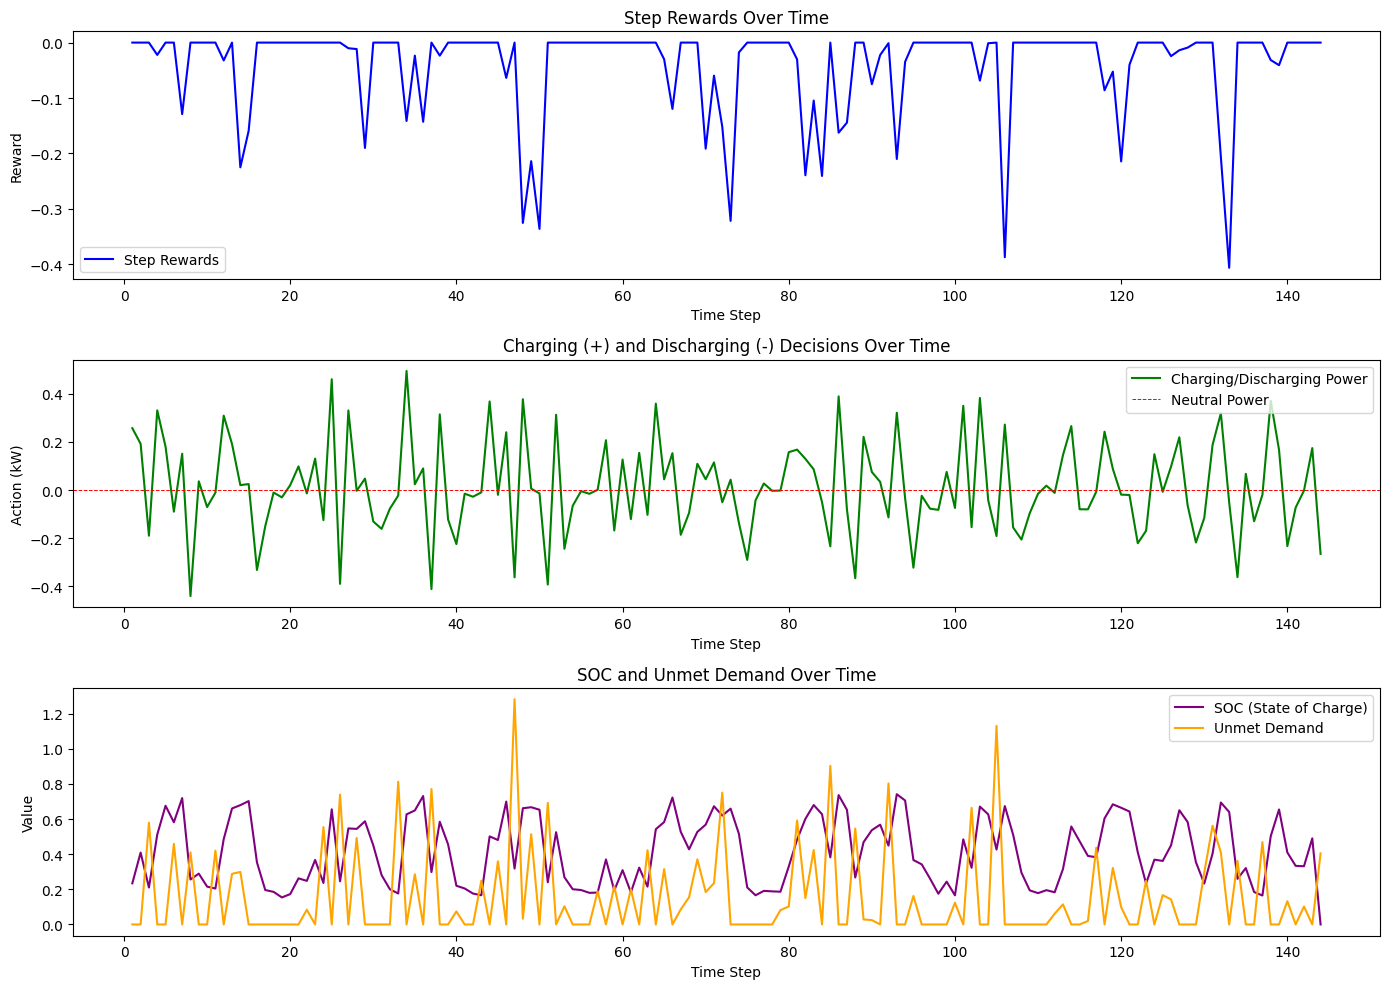

Total Reward on Test Data: -5.79
Total Steps: 144


In [4]:
import matplotlib.pyplot as plt

# 重置环境以便测试
obs = test_env.reset()
step_rewards = []  # 存储每一步的奖励
actions = []  # 存储每一步的动作
soc_values = []  # 存储每一步的 SOC 值
unmet_demands = []  # 存储每一步的未满足负荷
timestamps = []  # 存储时间戳
total_rewards = 0
steps = 0

while True:
    action, _ = model.predict(obs, deterministic=True)  
    obs, reward, done, info = test_env.step(action)  
    total_rewards += reward[0]
    steps += 1

    # 保存每步的信息
    step_rewards.append(reward[0])
    actions.append(action[0][0])  
    soc_values.append(obs[0][-1])  
    unmet_demand = max(0, obs[0][0] - (obs[0][2] + action[0][0]))  # 未满足负荷 = 用户负荷 - (光伏 + 动作)
    unmet_demands.append(unmet_demand)
    timestamps.append(steps)

    if done:
        break

# 绘制结果
plt.figure(figsize=(14, 10))

# 1. 奖励值变化
plt.subplot(3, 1, 1)
plt.plot(timestamps, step_rewards, label="Step Rewards", color="b")
plt.xlabel("Time Step")
plt.ylabel("Reward")
plt.title("Step Rewards Over Time")
plt.legend()

# 2. 充放电决策
plt.subplot(3, 1, 2)
plt.plot(timestamps, actions, label="Charging/Discharging Power", color="g")
plt.axhline(0, color="r", linestyle="--", linewidth=0.7, label="Neutral Power")
plt.xlabel("Time Step")
plt.ylabel("Action (kW)")
plt.title("Charging (+) and Discharging (-) Decisions Over Time")
plt.legend()

# 3. SOC 变化和未满足负荷
plt.subplot(3, 1, 3)
plt.plot(timestamps, soc_values, label="SOC (State of Charge)", color="purple")
plt.plot(timestamps, unmet_demands, label="Unmet Demand", color="orange")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("SOC and Unmet Demand Over Time")
plt.legend()

plt.tight_layout()
plt.show()

print(f"Total Reward on Test Data: {total_rewards:.2f}")
print(f"Total Steps: {steps}")
